# Welcome!
This is a notebook detailing my analysis of some data about motor theft in New Zealand over 6 months.
The records contain information about the vehicle, including its unique ID, type, make, manufacture year, color the location of the incident, the day it was added to the database.

I figured it was an appropriate phenomenon to study, considering the imminent announcement of GTA VI.

The dataset is kindly provided by the wonderful people at [Maven Analytics](mavenanalytics.io), it can be acquired there for free.

## Goals:
### Which vehicle types were stolen the most? 
- I don't know what to expect, it's a safe bet to rule vehicle types like mobile machines, and SPVs. I also expect sport cars to be stolen the least. Stealing a Kia is nothing like stealing a Ferrari.
### Have carjackings increased or decreased recently?
- Analyzing the changes and trends of the phenomenon.
### What day of the week are vehicles most often and least often stolen?
- I'm quite curious about this one! If you stole a car, what day would you choose to do it?
### Is the model year a factor? Does it affect a vehicle differently based on its type?
- I expect prized cars from the 80s and earlier to be prime targets, highly valuable (particularly Japanese cars) without as much security as say, a 2023 Mercedes.
### Which regions had the most carjackings?
- I have no idea what the New Zealand provinces are, but a little filled map action will sort us well.
### Which regions are above or below the average rate of thefts?
- Using **transform()**, we'll be able to analyze whether a region is safer than others or not.



## Let's start by importing all the libraries we'll need:


In [111]:
# pandas
import pandas as pd

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(15,8)
# seaborn, might need it
import seaborn as sns

#setting that shows seaborn visualizations instead of matplotlib's
sns.set()

# setting which plot style to use
sns.set_style('darkgrid')

#magic function that stores all the plots in the notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)

## Data Import and Preprocessing

### Next, we'll import our CSV files and perform some import pre-processing to save memory and time:
- First we import the carjackings dataframe itself using **read_csv()**, set the date parser to true with specified date format, and use smaller integer data types when possible, these preprocessing steps will save us both time and performance.


In [112]:
# little variable to help make the code more readable
veh_cols=["vehicle_id","vehicle_type","make_id","model_year","color","date_stolen","location_id"]

thefts = pd.read_csv("E:/projects/nz-motor-theft-py-analysis/stolen_vehicles.csv",
            usecols=veh_cols, # this will pass only the specified columns
            header=0, # setting the first row as the header
            parse_dates= ["date_stolen"], # allows pandas to directly make the date column a datetime64 type
            date_format= "%m/%d/%y", # helps pandas get the correct date format
            dtype={"vehicle_id": "Int16","make_id":"Int16","location_id":"Int16","model_year":"str"}, #notice the capital letter in the "Int"s, more on that later
            keep_default_na=True #keeps the NA values, so we'll be able to get rid of them later
)
thefts.sample(5)

,vehicle_id,vehicle_type,make_id,model_year,color,date_stolen,location_id
1237,1238,Roadbike,636,2021,Red,2022-03-14,109
59,60,Trailer,623,1983,Red,2022-01-02,108
2716,2717,Hatchback,576,2005,Silver,2022-02-28,102
625,626,Moped,585,2010,Blue,2021-12-26,102
527,528,Roadbike,611,2002,Black,2021-12-01,102


There's a lot of missing values here, and unfortunately we can't really do anything to fill them, so we'll have to get rid of them, but we'll save that for the cleaning stage.

- For now, we'll import the second CSV file, the make details table.

In [113]:
makes = pd.read_csv('E:/projects/nz-motor-theft-py-analysis/make_details.csv',
            index_col = "make_id",
            header=0, 
            dtype={"make_id":"Int16"},
            keep_default_na=True  
)
makes.sample(5)

,make_name,make_type
make_id,,
631,Victory,Standard
559,Jeep,Standard
504,Anglo,Standard
624,Trike,Standard
605,Skoda,Standard


What a pretty dataframe. We'll join it to the first table soon, using **merge()** - pandas' version of the SQL join, I love SQL, so I feel right at home.


- Now to import the location data:

In [114]:
location_cols=["location_id","region","population"] # columns to imported, there's only one country after all
locations = pd.read_csv('E:/projects/nz-motor-theft-py-analysis/locations.csv',
            index_col = "location_id",
            usecols=location_cols,
            header=0, 
            dtype={"location_id":"int8"},
            keep_default_na=True
  )
locations.head()

,region,population
location_id,,
101,Northland,"201,500"
102,Auckland,"1,695,200"
103,Waikato,"513,800"
104,Bay of Plenty,"347,700"
105,Gisborne,"52,100"


## Now that we have our data ready, it's time for cleaning.

- First, we'll check the stolen vehicles table:

In [115]:
thefts.shape

(4553, 7)

6 columns and 4527 rows, including the ones with missing data.

In [116]:
thefts.isna().sum() #first method will tell us if the value is missing or not


vehicle_id       0
vehicle_type    26
make_id         15
model_year      15
color           15
date_stolen      0
location_id      0
dtype: int64

Plenty of missing values. As mentioned before, we can't really fill them with anything, so we'll just get rid of any rows missing data using **dropna()**
Thankfully, it's only 26 rows. Negligible against the remaining 4520 (and header)

In [117]:
thefts = thefts.dropna(axis = 0, how = "any") #this will delete *any* rows that are missing values
thefts.isna().sum()

vehicle_id      0
vehicle_type    0
make_id         0
model_year      0
color           0
date_stolen     0
location_id     0
dtype: int64

I noticed that the list of vehicle types column is quite granular and could do with a little touch up. We'll use **contains()** nested in **where()** to replace any rows.


In [118]:
thefts["vehicle_type"].unique()

array(['Trailer', 'Boat Trailer', 'Roadbike', 'Moped', 'Trailer - Heavy',
       'Caravan', 'Hatchback', 'Saloon', 'Stationwagon', 'Tractor',
       'Trail Bike', 'Light Van', 'All Terrain Vehicle', 'Utility',
       'Other Truck', 'Sports Car', 'Flat Deck Truck', 'Light Bus',
       'Mobile Home - Light', 'Convertible', 'Heavy Van',
       'Special Purpose Vehicle', 'Articulated Truck',
       'Cab and Chassis Only', 'Mobile Machine'], dtype=object)

The way I see it:
- A trailer isn't that different to a boat trailer. <br>
- Vans should be a single category as well. <br>
- Some truck categories have too small a value, so we'll include those in a big truck category.
- Cab & Chassis Only trucks are simply trucks without the truck.<br>
- I will also change "Mobile Home - Light" into "Mobile Home" because there's only one type.<br>

I apologize, it's quite an ugly snippet of code, and yes, I did try to use the **regex** library, but it doesn't support Dataframes and Series. So, I ended up making this:

In [119]:
thefts['vehicle_type'] = thefts['vehicle_type'].where((thefts['vehicle_type'].str.contains('Trailer') == False), other="Trailer")
thefts['vehicle_type'] = thefts['vehicle_type'].where((thefts['vehicle_type'].str.contains('Truck') == False), other="Truck")
thefts['vehicle_type'] = thefts['vehicle_type'].where((thefts['vehicle_type'].str.contains('Van') == False), other="Van")
thefts['vehicle_type'] = thefts['vehicle_type'].where((thefts['vehicle_type'].str.contains('Bus') == False), other="Bus")
thefts['vehicle_type'] = thefts['vehicle_type'].where((thefts['vehicle_type'] != "Mobile Home - Light"), other="Mobile Home")
thefts['vehicle_type'] = thefts['vehicle_type'].where((thefts['vehicle_type'] != "Cab and Chassis Only"), other="Truck")
thefts['vehicle_type'].unique()

array(['Trailer', 'Roadbike', 'Moped', 'Caravan', 'Hatchback', 'Saloon',
       'Stationwagon', 'Tractor', 'Trail Bike', 'Van',
       'All Terrain Vehicle', 'Utility', 'Truck', 'Sports Car', 'Bus',
       'Mobile Home', 'Convertible', 'Special Purpose Vehicle',
       'Mobile Machine'], dtype=object)

It replaces any rows with the mention of a trailer with simply "trailer", van with "vans" and so on.
I spent over an hour trying to avoid that spaghetti but alas.

### We'll add a column for both days and months for some of our anaylses for later.

In [120]:
thefts["month"]= thefts["date_stolen"].dt.month
thefts["day"]= thefts["date_stolen"].dt.day_of_week
thefts.sample(5)


,vehicle_id,vehicle_type,make_id,model_year,color,date_stolen,location_id,month,day
2344,2345,Saloon,550,2002,Grey,2022-02-26,102,2,5
3130,3131,Stationwagon,550,2006,Brown,2022-02-09,108,2,2
869,870,Roadbike,611,2019,White,2022-02-16,109,2,2
790,791,Utility,576,2002,White,2021-12-29,106,12,2
3539,3540,Saloon,576,2003,White,2022-02-02,106,2,2


### Next, we'll check the makes table for any missing values, it's a lookup table, so I'm hoping nothing is missing.
Let's look at the shape:


In [121]:
makes.shape

(138, 2)

Let's check if any of these 138 rows are missing any data:


In [122]:
makes.isna().sum()

make_name    0
make_type    0
dtype: int64

None! What a relief.
Now, for the location table, it's likely the same, as it's a lookup table as well.

In [123]:
locations.shape

(16, 2)

In [124]:
locations.isna().sum()

region        0
population    0
dtype: int64

Success! There is no missing data in our lookup tables!

# Joining the Data tables:
For this, we'll use **merge()**, and NOT **join()** and keys like make_id and location_id. We'll do two tables at a time to keep the code more readable.

First, we'll join the theft and make tables, using the make_id column, which is common to both tables.

In [125]:
thefts_w_makes = thefts.merge(makes,"left",left_on=thefts["make_id"],right_index=True)
thefts_w_makes.head()

,vehicle_id,vehicle_type,make_id,model_year,color,date_stolen,location_id,month,day,make_name,make_type
0,1,Trailer,623,2021,Silver,2021-11-05,102,11,4,Trailer,Standard
1,2,Trailer,623,2021,Silver,2021-12-13,105,12,0,Trailer,Standard
2,3,Trailer,623,2021,Silver,2022-02-13,102,2,6,Trailer,Standard
3,4,Trailer,623,2021,Silver,2021-11-13,106,11,5,Trailer,Standard
4,5,Trailer,623,2018,Silver,2022-01-10,102,1,0,Trailer,Standard


Next, we'll join the location data, for the complete package:

In [126]:
thefts_full = thefts_w_makes.merge(locations,"left",left_on=thefts_w_makes["location_id"],right_index=True)
thefts_full.sample(5)

,vehicle_id,vehicle_type,make_id,model_year,color,date_stolen,location_id,month,day,make_name,make_type,region,population
1282,1283,Roadbike,601,2020,Black,2022-02-26,102,2,5,Royal Enfield,Standard,Auckland,"1,695,200"
2325,2326,Saloon,576,2003,Silver,2022-01-15,108,1,5,Mazda,Standard,Manawatū-Whanganui,"258,200"
1015,1016,Moped,566,2019,Red,2022-01-12,104,1,2,Kymco,Standard,Bay of Plenty,"347,700"
70,71,Trailer,623,2014,Silver,2022-02-24,107,2,3,Trailer,Standard,Taranaki,"127,300"
23,24,Trailer,623,2021,Silver,2021-11-12,102,11,4,Trailer,Standard,Auckland,"1,695,200"


Voilà! Now, we have the complete table, just like we would in SQL. We have the date of the theft, when and where it was committed, and which type of vehicle was stolen, etc. we are ready to aggregate!

# Aggregating and plotting the data:

In this step, we will:
- Aggregate the data by time, location, and make etc. to answer our questions.
- Use different visualizations to hopefully complete a sound and insightful analysis into this phenomenon.

### Which vehicle types were stolen the most? 
To answer this question, it's a simple process of summing the thefts by make type, using **groupby()** and **agg()**.
I also used **query()** to filter out types that have been stolen less than 5 times, and used the **plot()** method to do the, well, plotting.

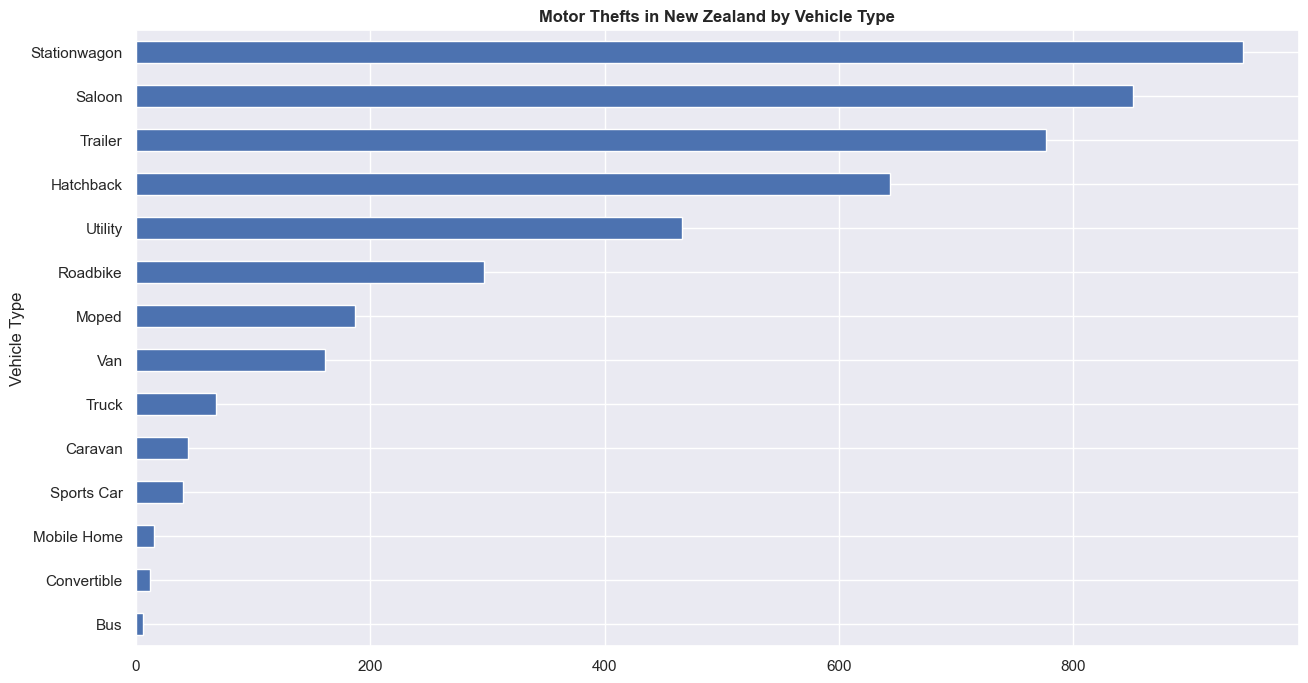

In [127]:
(thefts_full
.groupby('vehicle_type')
.agg(theft_count=('vehicle_id','count'))
.query("theft_count > 5")
.sort_values("theft_count", ascending=True)
.rename(columns={"theft_count":"Thefts"})
.plot(kind="barh", 
ylabel= "Vehicle Type",
legend=False))
plt.title("Motor Thefts in New Zealand by Vehicle Type", fontweight="bold");

When it comes to cars, we notice that saloons and station wagons reign supreme. Sport cars are often conspicuous and come with extra security features, as they're usually high end, making them harder to steal. Wagons are neat, the new V90 from Volvo looks amazing.

Trailers also seem to be stolen quite often, I'm still trying to wrap my head around how that would work, does the thief just bring a semi truck or tractor and takes it away? That doesn't seem too difficult now that I think about it.

### Has the number of carjacking increased recently?
Mostly the same code as last time, except this time we'll filter the values using **.loc()** only to January 2022, aggregate using the date column, and make a line chart.

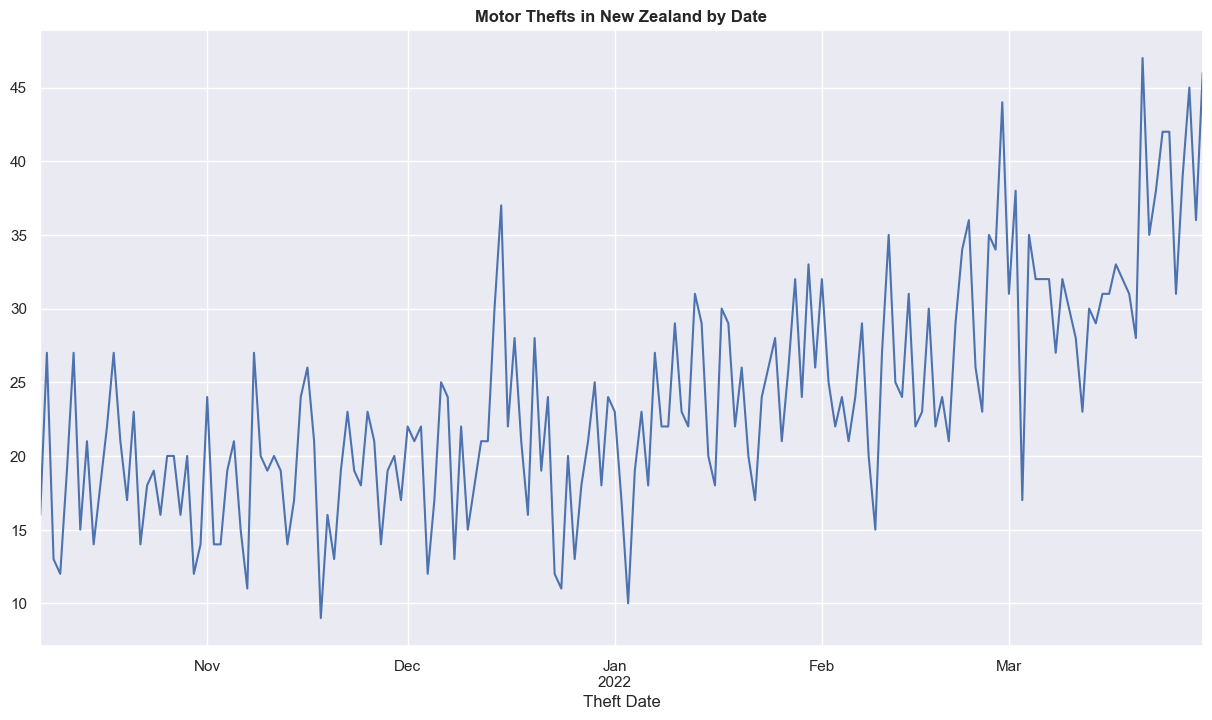

In [133]:
(thefts_full.loc[(thefts_full["date_stolen"] < "2022-03-31")]
.groupby('date_stolen')
.agg(theft_count=('vehicle_id','count'))
.rename(columns={"theft_count":"Thefts"})
.plot(kind="line", 
legend=False,
xlabel= "Theft Date"))
plt.title("Motor Thefts in New Zealand by Date", fontweight="bold");

We notice an increase after 2022, possibly due to the lift of COVID-19 regulations.

### What day of the week are vehicles most often and least often stolen?
A simple bar chart will do for this one.
We'll use an array of day numbers, and a list of day names, and run them in the xticks function. I initially tried to do this with a dictionary, but that surprisingly didn't work!

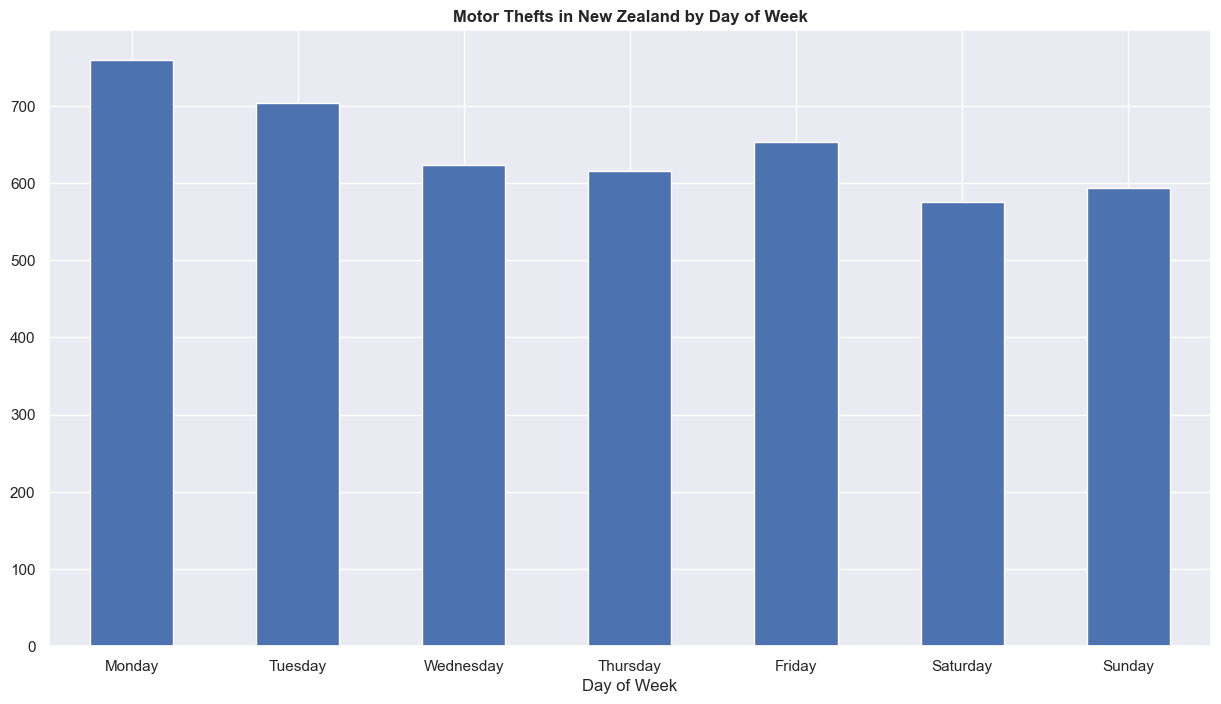

In [129]:
day_of_week = [0,1,2,3,4,5,6]
day_name = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
(thefts_full
.groupby("day")
.agg(theft_count=('vehicle_id','count'))
.rename(columns={"theft_count":"Thefts"})
.plot(kind="bar", 
legend=False,
xlabel= "Day of Week"))
plt.xticks(ticks= day_of_week, labels = day_name, rotation=0)
plt.title("Motor Thefts in New Zealand by Day of Week", fontweight="bold");

Early days of the week seem to have more thefts than the rest of the week. There's a slight increase on Fridays but not as much as Mondays and Tuesdays.
Getting your car stolen on Monday seems like a terrific way to start your week.

### Is the model year a factor?
I wanted to use a line chart for this one, for a little variety, but it is not a time series analysis! Almost made a huge mistake there.

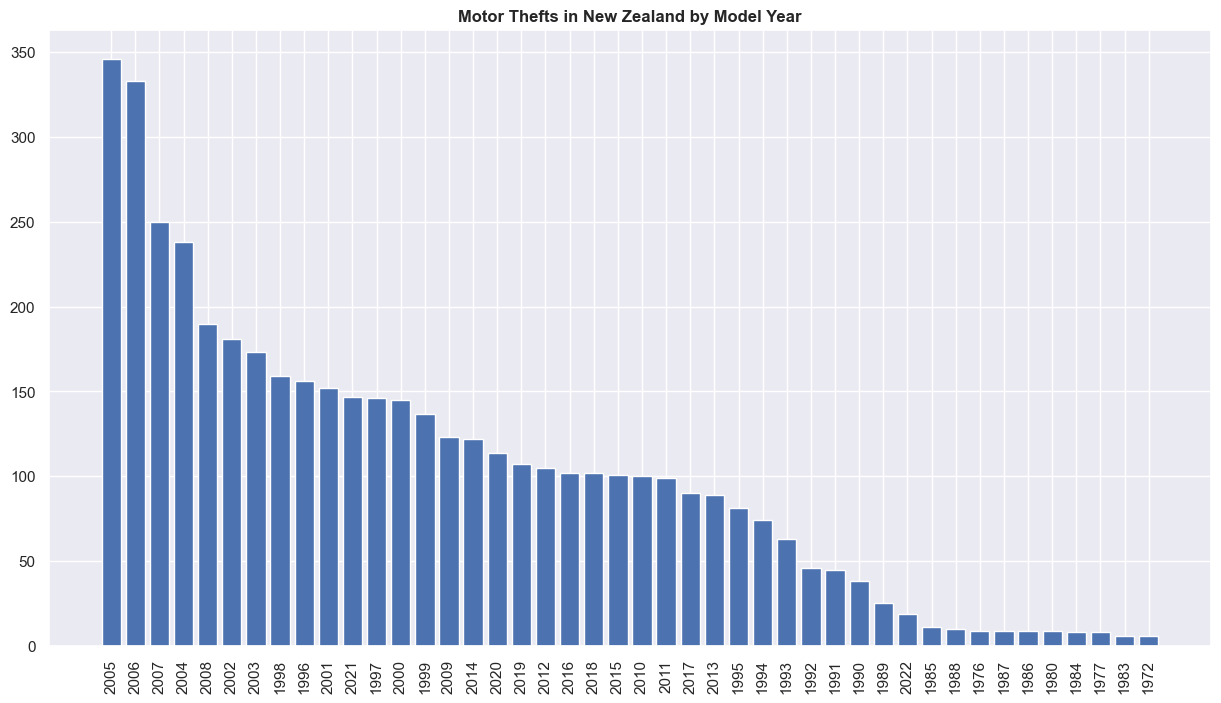

In [134]:
m_year = (thefts_full
.groupby('model_year')
.agg(theft_count=('vehicle_id','count'))
.query("theft_count > 5")
.rename(columns={"theft_count":"Thefts"})
.sort_values("Thefts", ascending=False)
)

m_year = m_year.reset_index()
plt.bar(x=m_year['model_year'],
        height=m_year['Thefts'],)
plt.xticks(rotation=90)
#plt.figure(figsize=(2,2))
plt.title("Motor Thefts in New Zealand by Model Year", fontweight="bold")
plt.show()

It seems that cars made in the mid 2000s are the most popular targets. They're in the sweet spot between old and modern - not too old that they're falling apart, nor too new that they're difficult to steal. And the further back we go, there's very small thefts, as classic and vintage cars are too conspicuous to be stolen (most of the time). <br>
And no mob bosses would drive a 2005 car! Except if said mob boss has exquisite taste and drives an Audi A8L D3 with the W12 (yes it's one of my dream cars)